In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import requests
from pprint import pprint
import time
import os
import plotly.express as px

In [2]:
# Lo primero es importar los datos descargados de airtable que tenemos almacenados en un excel para hacer gráficas. 
ruta_equipos_nba = 'excels/descargados/datos_equipos_nba.xlsx'
ruta_jugadores_nba = 'excels/descargados/datos_jugadores_nba.xlsx'

df_equipos_nba = pd.read_excel(ruta_equipos_nba)
df_jugadores_nba = pd.read_excel(ruta_jugadores_nba)

In [4]:
# Vamos a calcular de todos los jugadores respecto a los partidos jugados la media, varianza y quartiles 1 y 3 de todos sus datos

# Lo primero vamos a crear un nuevo dataframe que sea copia del original para trabajar en él y tener el original por si
# necesitamos incorporar algún dato sin modificar

df_estadisticas_jugadores = df_jugadores_nba.copy()
# Calculamos la media
estadisticas = ['MIN', 'PTS', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'EFF']
for stat in estadisticas:
    df_estadisticas_jugadores[stat + '_por_GP'] = df_estadisticas_jugadores[stat] / df_estadisticas_jugadores['GP']

# Vamos a quitar los datos de los jugadores que no hayan jugado ningún partido para no dividir entre 0
df_estadisticas_jugadores = df_estadisticas_jugadores[df_estadisticas_jugadores['GP'] != 0]

# Y hacemos lo mismo con la varianza y quartiles
varianzas = df_estadisticas_jugadores[estadisticas].var()
cuartiles = df_estadisticas_jugadores[estadisticas].quantile([0.25, 0.75])


In [7]:
# Ahora lo que quiero es asignar puntos a los jugadores de una escala entre 0 para el peor y 10 para el mejor
# Pero me he inventado un sistema de puntuación en el que los que están en el q3 estén más valorados y los que
# esten en el q1 están menos valorados. Además voy a introducir también la varianza para analizar si la estadística
# media de un jugador es significativamente mayor o menos que la varianza media para ese dato. 
# No es del todo exacto, pero bueno, es una forma de distribuir puntos de 0 a 10 a los jugadores para intentar
# encontrar quiene es el mejor mejor y quien es el peor peor y los que están por la media para tener un valor carta FIFA.

# Paso 2: Normalizar las estadísticas
def normalizar_min_max(df, columnas):
    for columna in columnas:
        minimo = df[columna].min()
        maximo = df[columna].max()
        df[columna + '_normalizado'] = 10 * (df[columna] - minimo) / (maximo - minimo)
    return df

columnas_normalizadas = [stat + '_por_GP' for stat in estadisticas]
df_estadisticas_normalizadas = normalizar_min_max(df_estadisticas_jugadores, columnas_normalizadas)

# Paso 3: Ajustar puntuaciones según los cuartiles
def ajustar_por_cuartiles(df, columnas, q1, q3, incremento_q3, decremento_q1):
    for columna in columnas:
        df.loc[df[columna] > q3[columna.replace('_normalizado', '')], columna] += incremento_q3
        df.loc[df[columna] < q1[columna.replace('_normalizado', '')], columna] -= decremento_q1
        df[columna] = df[columna].clip(lower=0, upper=10)
    return df

cuartiles = df_estadisticas_jugadores[columnas_normalizadas].quantile([0.25, 0.75])
incremento_q3 = 1
decremento_q1 = 1
df_puntuaciones_ajustadas = ajustar_por_cuartiles(df_estadisticas_normalizadas, [col + '_normalizado' for col in columnas_normalizadas], cuartiles.loc[0.25], cuartiles.loc[0.75], incremento_q3, decremento_q1)

# Paso 4: Ajustar puntuaciones según la varianza
def ajustar_por_varianza(df, columnas, varianzas, umbral_varianza, ajuste_varianza):
    varianza_media = varianzas.mean()
    for columna in columnas:
        varianza_columna = df[columna.replace('_normalizado', '')].var()
        if varianza_columna > varianza_media * umbral_varianza:
            df[columna] -= ajuste_varianza
        elif varianza_columna < varianza_media / umbral_varianza:
            df[columna] += ajuste_varianza
        df[columna] = df[columna].clip(lower=0, upper=10)
    return df

umbral_varianza = 1.5
ajuste_varianza = 0.5
df_puntuaciones_finales = ajustar_por_varianza(df_puntuaciones_ajustadas, [col + '_normalizado' for col in columnas_normalizadas], varianzas, umbral_varianza, ajuste_varianza)

In [9]:
print(df_puntuaciones_finales[['Nombre', 'Apellido', 'PTS_por_GP_normalizado']].sort_values(by='PTS_por_GP_normalizado', ascending=False))


      Nombre            Apellido  PTS_por_GP_normalizado
166     Luka              Doncic               10.000000
379     Joel              Embiid               10.000000
482     Shai  Gilgeous-Alexander                9.596257
418  Giannis       Antetokounmpo                9.580214
241    Kevin              Durant                9.057219
..       ...                 ...                     ...
286     Alex               Fudge                0.500000
287     Seth               Lundy                0.500000
289    Usman              Garuba                0.500000
292  Jamaree              Bouyea                0.500000
520     E.J.             Liddell                0.500000

[521 rows x 3 columns]


In [20]:
# Ahora vamos a calcular la media de puntos que han obtenido y ver cual es el mejor jugador según nuestros cáculos de la NBA

columnas_puntuaciones = [stat + '_por_GP_normalizado' for stat in estadisticas]
df_puntuaciones_finales['Puntuacion_Total'] = df_puntuaciones_finales[columnas_puntuaciones].mean(axis=1)

# Y quiero expresar el resultado en formato tarjeta FIFA que es valoración de 1 a 100
df_puntuaciones_finales['Puntuacion_Total'] = (df_puntuaciones_finales['Puntuacion_Total'] * 10).round(2)

print(df_puntuaciones_finales[['Nombre', 'Apellido', 'Puntuacion_Total']].sort_values(by='Puntuacion_Total', ascending=False))


      Nombre       Apellido  Puntuacion_Total
379     Joel         Embiid             83.90
166     Luka         Doncic             83.28
418  Giannis  Antetokounmpo             78.91
27    Jayson          Tatum             74.62
218   Nikola          Jokic             74.26
..       ...            ...               ...
57    Dmytro     Skapintsev              5.00
75   Onuralp          Bitim              5.00
262      Jay           Huff              5.00
399  Malcolm        Cazalon              5.00
404  Kendall          Brown              5.00

[521 rows x 3 columns]


In [31]:
# Ahora se me ha ocurrido asignarle valores fictios monetarios en dólares a los jugadores de la NBA
# Entonces, siguiendo el mismo modelo que ya empleamos para repartir puntos contemplando los mejores y 
# peores con los Q3 y Q1, y con la corrección de la varianza asignar valores monetarios con la puntuación
# total entre 300 millones de dólares y 5 millones de dólares

# Parámetros de valoración
valor_maximo = 300  # En millones de dólares
valor_minimo = 5    # En millones de dólares
puntuacion_maxima = 100

# Escalar el valor monetario base según la puntuación
def escalar_valor_monetario(puntuacion, valor_minimo, valor_maximo, puntuacion_maxima):
    return ((valor_maximo - valor_minimo) / puntuacion_maxima) * puntuacion + valor_minimo

def ajustar_valor_monetario(df, valor_minimo, valor_maximo, puntuacion_maxima, q1_total, q3_total, varianza_total, umbral_varianza, ajuste_cuartiles, ajuste_varianza):
    df['Valor_Monetario'] = df['Puntuacion_Total'].apply(lambda x: escalar_valor_monetario(x, valor_minimo, valor_maximo, puntuacion_maxima))

    # Ajuste por cuartiles
    df.loc[df['Puntuacion_Total'] > q3_total, 'Valor_Monetario'] += ajuste_cuartiles
    df.loc[df['Puntuacion_Total'] < q1_total, 'Valor_Monetario'] -= ajuste_cuartiles

    # Ajuste por varianza
    if varianza_total > umbral_varianza:
        df['Valor_Monetario'] -= ajuste_varianza
    elif varianza_total < umbral_varianza:
        df['Valor_Monetario'] += ajuste_varianza

    df['Valor_Monetario'] = df['Valor_Monetario'].clip(lower=valor_minimo, upper=valor_maximo)
    return df

# Parámetros adicionales para el ajuste
ajuste_cuartiles = 15  # Ajuste monetario para jugadores en los cuartiles superior e inferior
ajuste_varianza = 10   # Ajuste monetario para la varianza

# Calcula 'Puntuacion_Total'
columnas_puntuaciones = [stat + '_por_GP_normalizado' for stat in estadisticas]
df_puntuaciones_finales['Puntuacion_Total'] = df_puntuaciones_finales[columnas_puntuaciones].mean(axis=1)

# Convertir 'Puntuacion_Total' a escala de 0 a 100, si aún no se ha hecho
df_puntuaciones_finales['Puntuacion_Total'] = (df_puntuaciones_finales['Puntuacion_Total'] * 10).round(2)

# Aplicar ajustes al valor monetario con los nuevos cuartiles y varianza
if 'Puntuacion_Total' in df_puntuaciones_finales.columns:
    df_puntuaciones_finales = ajustar_valor_monetario(df_puntuaciones_finales, valor_minimo, valor_maximo, puntuacion_maxima, q1_total, q3_total, varianza_total, umbral_varianza, ajuste_cuartiles, ajuste_varianza)

# Imprimir el resultado
print(df_puntuaciones_finales[['Nombre', 'Apellido', 'Puntuacion_Total', 'Valor_Monetario']].sort_values(by='Valor_Monetario', ascending=False))

      Nombre       Apellido  Puntuacion_Total  Valor_Monetario
379     Joel         Embiid             83.90         257.5050
166     Luka         Doncic             83.28         255.6760
418  Giannis  Antetokounmpo             78.91         242.7845
27    Jayson          Tatum             74.62         230.1290
218   Nikola          Jokic             74.26         229.0670
..       ...            ...               ...              ...
236    Chris     Livingston              6.98           5.0000
239  Aleksej     Pokusevski              8.30           5.0000
451    Jacob         Toppin              6.19           5.0000
253   Damian          Jones              8.31           5.0000
520     E.J.        Liddell              8.25           5.0000

[521 rows x 4 columns]


In [33]:
list(df_puntuaciones_finales)

['id_jugador',
 'Nombre',
 'Apellido',
 'ID Equipo',
 'Dorsal',
 'Posición',
 'PPG',
 'RPG',
 'APG',
 'PIE',
 'Altura (metros)',
 'Peso (kg)',
 'País',
 'Último Equipo',
 'Edad',
 'Cumpleaños',
 'Draft',
 'Experiencia',
 'GP',
 'MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG%',
 '3PM',
 '3PA',
 '3P%',
 'FTM',
 'FTA',
 'FT%',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'EFF',
 'AST/TOV',
 'STL/TOV',
 'MIN_por_GP',
 'PTS_por_GP',
 'FGM_por_GP',
 'FGA_por_GP',
 '3PM_por_GP',
 '3PA_por_GP',
 'FTM_por_GP',
 'FTA_por_GP',
 'OREB_por_GP',
 'DREB_por_GP',
 'REB_por_GP',
 'AST_por_GP',
 'STL_por_GP',
 'BLK_por_GP',
 'TOV_por_GP',
 'PF_por_GP',
 'EFF_por_GP',
 'MIN_por_GP_normalizado',
 'PTS_por_GP_normalizado',
 'FGM_por_GP_normalizado',
 'FGA_por_GP_normalizado',
 '3PM_por_GP_normalizado',
 '3PA_por_GP_normalizado',
 'FTM_por_GP_normalizado',
 'FTA_por_GP_normalizado',
 'OREB_por_GP_normalizado',
 'DREB_por_GP_normalizado',
 'REB_por_GP_normalizado',
 'AST_por_GP_normalizado',
 'STL_

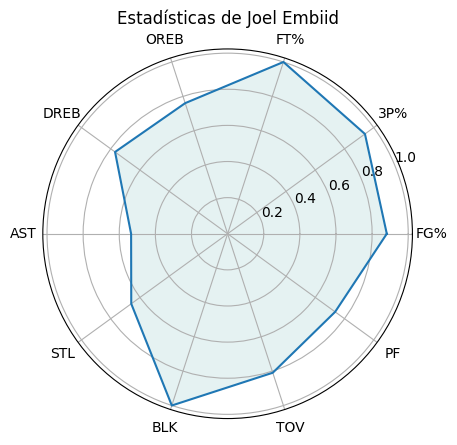

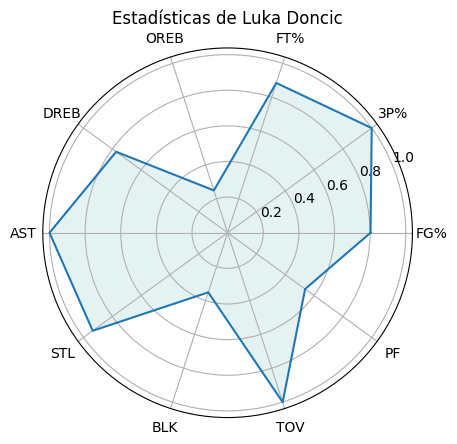

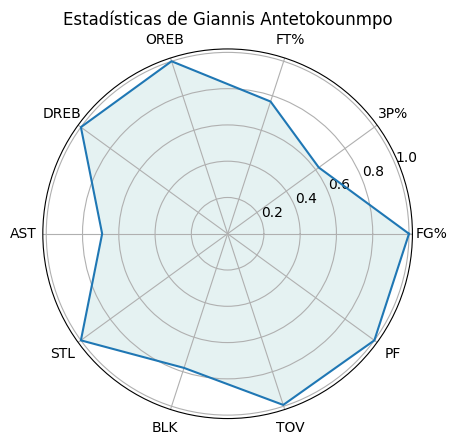

In [35]:
# Ya tenemos los cálculos hechos... ahora vamos a graficar
# Primero vamos a poner el top3 de jugadores ofensivos en un gráfico tipo radar 

# Categorías para el gráfico de radar
categorias = ['FG%', '3P%', 'FT%', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TOV', 'PF']
N = len(categorias)

# Ordenamos los jugadores por 'Puntuacion_Total' y seleccionamos los top 3
top_jugadores = df_puntuaciones_finales.sort_values(by='Puntuacion_Total', ascending=False).head(3)

# Normalizamos las estadísticas para cada jugador
for cat in categorias:
    max_value = top_jugadores[cat].max()
    if max_value > 0:
        top_jugadores[cat] = top_jugadores[cat] / max_value

# Crear un gráfico de radar para cada jugador
for index, jugador in top_jugadores.iterrows():
    valores = [jugador[cat] for cat in categorias] + [jugador[categorias[0]]]  # Repite el primer valor al final para cerrar el círculo
    angulos = [n / float(N) * 2 * np.pi for n in range(N)]
    angulos += angulos[:1]

    ax = plt.subplot(111, polar=True)
    plt.xticks(angulos[:-1], categorias)

    ax.plot(angulos, valores)
    ax.fill(angulos, valores, 'teal', alpha=0.1)

    plt.title(f"Estadísticas de {jugador['Nombre']} {jugador['Apellido']}")
    plt.show()




In [39]:
import plotly.graph_objects as go

for cat in categorias:
    max_value = top_jugadores[cat].max()
    if max_value > 0:
        top_jugadores[cat] = (top_jugadores[cat] / max_value) * 10

# Crear un gráfico de radar para cada jugador
for index, jugador in top_jugadores.iterrows():
    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=[jugador[cat] for cat in categorias] + [jugador[categorias[0]]],  # Repite el primer valor al final para cerrar el círculo
        theta=categorias + [categorias[0]],
        fill='toself',
        name=f"{jugador['Nombre']} {jugador['Apellido']}"
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 10]
            )),
        showlegend=False,
     
        title=f"Valor de puntuaciones de las estadísticas de {jugador['Nombre']} {jugador['Apellido']}"
    )

    fig.show()


In [46]:
# Ahora quiero insertar los gráficos en una imagen para crear la ficha tipo FIFA para la NBA
# He estado investigando a ver como hacerlo.
# Primero hay que guardar los gráficos en png

# Crear la carpeta si no existe
carpeta = 'fichas_nba/'
if not os.path.exists(carpeta):
    os.makedirs(carpeta)

# Obtener los 10 primeros jugadores por 'Puntuacion_Total'
top_10_jugadores = df_puntuaciones_finales.sort_values(by='Puntuacion_Total', ascending=False).head(10)

# Categorías para normalizar y graficar
categorias = ['FG%', '3P%', 'FT%', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TOV', 'PF']

# Crear y guardar un gráfico de radar para cada jugador
for index, jugador in top_10_jugadores.iterrows():
    # Normalizar las estadísticas para el jugador actual
    jugador_normalizado = jugador.copy()
    for cat in categorias:
        max_value = top_10_jugadores[cat].max()
        if max_value > 0:
            jugador_normalizado[cat] = (jugador[cat] / max_value) * 10

    fig = go.Figure()

    fig.add_trace(go.Scatterpolar(
        r=[jugador_normalizado[cat] for cat in categorias] + [jugador_normalizado[categorias[0]]],
        theta=categorias + [categorias[0]],
        fill='toself'
    ))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(visible=True, range=[0, 10])
        ),
        showlegend=False,
        paper_bgcolor='rgba(0,0,0,0)',  # Fondo transparente
        plot_bgcolor='rgba(0,0,0,0)'   # Fondo transparente
    )

    # Nombre del archivo
    nombre_archivo = f"{jugador['Nombre']}_{jugador['Apellido']}.png"

    # Guardar el gráfico como PNG con fondo transparente
    fig.write_image(carpeta + nombre_archivo, width=430, height=600, scale=1, format='png')

In [85]:
from PIL import Image, ImageDraw, ImageFont

# Carpeta de las imágenes y logos
carpeta_imagenes = 'fichas_nba/'
carpeta_logos = 'logos_equipos/png/'
ruta_fuente = "c:/windows/fonts/arialn.ttf"
tamaño_fuente_grande = 60
tamaño_fuente_pequeña = 36
tamaño_fuente_mediana = 52
tamaño_fuente_muy_grande = 90
fuente_grande = ImageFont.truetype(ruta_fuente, tamaño_fuente_grande)
fuente_pequeña = ImageFont.truetype(ruta_fuente, tamaño_fuente_pequeña)
fuente_mediana = ImageFont.truetype(ruta_fuente, tamaño_fuente_mediana)
fuente_muy_grande = ImageFont.truetype(ruta_fuente, tamaño_fuente_muy_grande)
categorias_datos = {
    'PTS_por_GP_normalizado': 'Puntos',
    '3PM_por_GP_normalizado': 'Triples',
    'FTM_por_GP_normalizado': 'Tiros Libres',
    'OREB_por_GP_normalizado': 'Rebotes Of.',
    'DREB_por_GP_normalizado': 'Rebotes Def.',
    'AST_por_GP_normalizado': 'Asistencias',
    'STL_por_GP_normalizado': 'Robos',
    'BLK_por_GP_normalizado': 'Bloqueos',
    'TOV_por_GP_normalizado': 'Pérdidas',
    'PF_por_GP_normalizado': 'Faltas'
}
espaciado_vertical = 70  

# Obtener los 10 primeros jugadores
top_10_jugadores = df_puntuaciones_finales.sort_values(by='Puntuacion_Total', ascending=False).head(10)

for index, jugador in top_10_jugadores.iterrows():
    # Cargar la imagen de fondo
    imagen_fondo = Image.open(carpeta_imagenes + 'tarjeta_base_nba.png')

    # Cargar y colocar la gráfica de radar
    nombre_grafica = f"{jugador['Nombre']}_{jugador['Apellido']}.png"
    grafica_radar = Image.open(carpeta_imagenes + nombre_grafica)
    grafica_radar = grafica_radar.resize((700, 977))
    imagen_fondo.paste(grafica_radar, (450, 150), grafica_radar)

    # Cargar y colocar el logo del equipo
    id_equipo = jugador['ID Equipo']
    logo_equipo = Image.open(carpeta_logos + f"{id_equipo}.png")
    logo_equipo = logo_equipo.resize((300, 300))  # Redimensionar el logo a 200x200
    imagen_fondo.paste(logo_equipo, (150, 300), logo_equipo)

    # Instancia para dibujar en la imagen
    draw = ImageDraw.Draw(imagen_fondo)

    # Texto para Nombre y Apellido con fuente grande
    texto_nombre = f"{jugador['Nombre']}"
    texto_apellido = f"{jugador['Apellido']}"
    draw.text((150, 600), texto_nombre, fill=(0, 0, 0), font=fuente_grande)
    draw.text((150, 680), texto_apellido, fill=(0, 0, 0), font=fuente_grande)

    # Texto para Edad/Dorsal con fuente pequeña
    edad = int(jugador['Edad']) if pd.notna(jugador['Edad']) else '#'
    dorsal = int(jugador['Dorsal']) if pd.notna(jugador['Dorsal']) else '#'
    texto_edad_dorsal = f"Edad: {edad} / Dorsal: {dorsal}"
    draw.text((150, 780), texto_edad_dorsal, fill=(0, 0, 0), font=fuente_pequeña)

    # Texto para el País con fuente pequeña
    texto_pais = f"País: {jugador['País']}"
    draw.text((150, 840), texto_pais, fill=(0, 0, 0), font=fuente_pequeña)

    for i, (clave, valor) in enumerate(categorias_datos.items()):
        texto_dato = f"{valor}: {jugador[clave]:.1f}"  # Redondear a 1 decimal
        x = 120 if i < 5 else 650  # Posición x para la primera o segunda columna
        y = 1000 + (i % 5) * espaciado_vertical  # Posición y

        draw.text((x, y), texto_dato, fill=(255, 255, 255), font=fuente_mediana)

    # Añadir Puntuacion_Total con fuente grande
    texto_puntuacion_total = f"Puntos Totales: {jugador['Puntuacion_Total']:.1f}"  # Redondear a 1 decimal
    posicion_puntuacion_total = (150, 1400)  # Ajusta la posición según sea necesario
    draw.text(posicion_puntuacion_total, texto_puntuacion_total, fill=(255, 255, 255), font=fuente_muy_grande)

    # Añadir Valor_Monetario con fuente grande
    texto_valor_monetario = f"Precio del Jugador: ${jugador['Valor_Monetario']:.2f}M"  # Formatear como precio en millones
    posicion_valor_monetario = (150, 1550)  # Ajusta la posición según sea necesario
    draw.text(posicion_valor_monetario, texto_valor_monetario, fill=(255, 255, 255), font=fuente_grande)

    # Guardar la imagen final
    nombre_tarjeta = f"{jugador['Nombre']}_{jugador['Apellido']}_tarjeta.png"
    imagen_fondo.save(carpeta_imagenes + nombre_tarjeta)
